In [3]:
import elephant as el
import pandas as pd
from functools import reduce
import os
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

#### Open datasets

In [4]:
main_path = 'E:/EPHYS/data/'
# Open SWR events
ripples_classified = pd.read_csv(os.path.join(main_path, 'ripples_classified.csv'))

### Apply exclusion window 

In [5]:
# Add exclusion window
ripples_sorted=ripples_classified.sort_values(['session_code','start_time'], ascending=True)
ripples_sorted['time_diff_to_previous']=ripples_sorted.groupby(['session_code']).start_time.diff()
ripples_sorted['time_diff_to_next']=ripples_sorted.groupby(['session_code']).start_time.diff(-1)

In [6]:
# Select exclusion window size
window_size=0.3

exclusion_mask =(
    ((ripples_sorted.time_diff_to_previous>=window_size) & \
     (ripples_sorted.time_diff_to_next <= - window_size)) |\
    # for first ripple of sessions
    ((ripples_sorted.time_diff_to_previous.isna()) & \
     (ripples_sorted.time_diff_to_next <= - window_size)) |\
    # for last ripple of sessions
    ((ripples_sorted.time_diff_to_previous >= window_size) & \
     (ripples_sorted.time_diff_to_next.isna()))
)

# Get ripples for analysis
ripples_analysis=ripples_sorted[exclusion_mask]

In [7]:
len(ripples_analysis)

722

In [8]:
ripples_analysis.head()

,start_time,end_time,trial_nr,outcome,run_type,rat_code,session_code,x_ripple,y_ripple,duration_sec,duration_ms,phase,time_diff_to_previous,time_diff_to_next
706,127.722667,127.870000,1.0,1.0,S,MAG,20190126160731,179.647251,185.001791,0.147333,147.333333,Sample,3.162333,-1.289667
707,129.012333,129.256000,1.0,1.0,S,MAG,20190126160731,179.584625,183.255619,0.243667,243.666667,Sample,1.289667,-9.183333
708,138.195667,138.286667,1.0,1.0,S,MAG,20190126160731,179.700000,178.247898,0.091000,91.000000,Sample,9.183333,-0.313667
709,138.509333,138.585000,1.0,1.0,S,MAG,20190126160731,179.671536,178.062212,0.075667,75.666667,Sample,0.313667,-1.380000
710,139.889333,139.945000,1.0,1.0,S,MAG,20190126160731,207.251575,142.120470,0.055667,55.666667,Sample,1.380000,-5.138667


### Label ripples by chunk

So we only need of open CG data from the chunks required

In [9]:
folders=os.listdir(main_path)
# Add path to each ripple
ripples_analysis['path']=ripples_analysis.apply(lambda x: 
                                            [f for f in folders if str(x.session_code) in f][0], 
                                            axis=1)


<ipython-input-9-8d13a5000c6e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ripples_analysis['path']=ripples_analysis.apply(lambda x:


In [10]:
chunk_info = pd.DataFrame(columns=['session', 'nr', 't_first', 't_final'])

# For each path and ephys csv file get first and last timestamps
for folder in ripples_analysis.path.unique():
    
    timestamps_path = os.path.join(main_path, folder, 'Ephys_timestamps')
    
    for csv in os.listdir(timestamps_path):
        
        # Get first and last timestamps from each ephys timestamps csv
        csv_content = pd.read_csv(os.path.join(timestamps_path, csv))
        t1 = csv_content.head(1)['0'].iloc[0]
        tn = csv_content.tail(1)['0'].iloc[0]
        # Store all info in dataframe
        row = pd.DataFrame([{
            'session':folder, 
            'nr': re.search(r'([0-9]{1,2})', csv).group(1),
            't_first': t1,
            't_final': tn}])
        chunk_info = pd.concat([chunk_info, row])

chunk_info = chunk_info.reset_index(drop=True)

In [11]:
def associate_ripples_with_chunk_file(row, chunk_info):
    
    '''
    Add chunk number to row using the chunk_info dataframe
    '''
    mask = (chunk_info['session']==row['path']) & \
        (
        # check for ripple start time
        ((chunk_info['t_first']<=row['start_time']) & (chunk_info['t_final']>=row['start_time'])) |\
        # check for ripple end time
        ((chunk_info['t_first']<=row['start_time']) & (chunk_info['t_final']>=row['start_time']))
        )
    
    # Get match(es)
    chunk=chunk_info[mask]
    
    if  len(chunk)==1:
        return pd.Series([chunk.nr.iloc[0], np.nan])
    elif len(chunk==2):
        return pd.Series([chunk.nr.iloc[0], chunk.nr.iloc[1]])
    else:
        return np.nan, np.nan
    

In [12]:
#  Add chunk number to row using the chunk_info dataframe based on start and end time of ech ripple
ripples_analysis[['chunk_start', 'chunk_end']]=ripples_analysis.apply(associate_ripples_with_chunk_file, args=(chunk_info,), axis=1)

C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Get data from CG tetrodes

This section includes:
- Order ripples_analysis by dataset and label ripple events (numbering);
- Randomly select 5 tetrodes to sample from each dataset;
- For each dataset x tt x chunk combination, open the tetrode data and collect 500 ms before and after each event. Store in a dataframe;

In [13]:
# Order by dataset and label ripple events
# This will be the ref_id to cross between ripples_analysis and the dataframe containing ephys data
ripples_analysis.sort_values(by=['path', 'chunk_start'], inplace=True)
ripples_analysis['ripple_nr']=range(0,len(ripples_analysis))

# Calculate timestamps to read for each ripple
window=.5
ripples_analysis['ephys_tfirst']=ripples_analysis['start_time']-window
ripples_analysis['ephys_tlast']=ripples_analysis['start_time']+window

<ipython-input-13-f7254b1483e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ripples_analysis.sort_values(by=['path', 'chunk_start'], inplace=True)
<ipython-input-13-f7254b1483e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ripples_analysis['ripple_nr']=range(0,len(ripples_analysis))
<ipython-input-13-f7254b1483e3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [14]:
# Create list with CG tetrode folder names
cg_tetrodes =['TT{}'.format(tt_nr) for tt_nr in range(1,15)]

In [15]:
# Open chunks and collect ephys data from random CG tetrodes
data_stored=dict()

for dataset in ripples_analysis.path.unique():
    print('Collecting for dataset: {}'.format(dataset))

    # ----- Random acquisition of tetrodes: 5 x dataset -------
    tt_folders = [f for f in os.listdir(os.path.join(main_path, dataset)) if f in cg_tetrodes]
    random_tt_folders = random.sample(tt_folders, 5)
    
    # ----- Getting chunks to read -------
    chunk_list = list(ripples_analysis[ripples_analysis.path==dataset].chunk_start.unique())
    chunk_end_list = list(ripples_analysis[ripples_analysis.path==dataset].chunk_end.unique())
    
    # To detect edge cases in which a ripple might start in one chunk and finish in the following  
    if len(chunk_end_list)>1:
        print('  NEED TO ADD END TIMES CHUNK!!!!')
        break
    else:
        pass
    
    # ----- Read data from chunks ------    
    
    for chunk_nr in chunk_list:       
        print('  Reading chunk {}...'.format(chunk_nr))
            
        # -- Read timestamps
        print('    Getting timestamps from {}...'.format('timestamps_chunk{}.csv'.format(chunk_nr)))
        timestamps = pd.read_csv(
                            os.path.join(
                            main_path, 
                            dataset,
                            'Ephys_timestamps', 
                            'timestamps_chunk{}.csv'.format(chunk_nr)))
            
        # -- Get info from ripples in chunk
        ripples_in_chunk=ripples_analysis[(ripples_analysis.path==dataset) &\
                                              (ripples_analysis.chunk_start==chunk_nr)]
        
        print('     Getting data for {} ripples in chunk...'.format(len(ripples_in_chunk)))
            
        # -- Read ephys data 
        
        # For each random CG tetrode read chunks and collect data
        for ripple_nr in ripples_in_chunk.ripple_nr:
            data_stored[ripple_nr]=[]
                
        for folder in random_tt_folders:
                
            file_to_read = '{}_chunk{}.csv'.format(folder, chunk_nr)          
                
            # Get ripples ephys from that chunk
            print('       Reading from {}...'.format(file_to_read))
            
            chunk_data = pd.read_csv(os.path.join(
                main_path, 
                dataset, 
                folder,
                file_to_read))
                
            # Timestamps and chunk data must be the same length. 
            # Otherwise they might be wrongly paired or have differences due to
            # crashes
            try:
                assert len(chunk_data)==len(timestamps)
            except: 
                print("Length difference found! Chunk len:{}, Timestamps len: {}".format(
                len(chunk_data), len(timestamps)))
                continue
                        
                
            # Select data for each ripple
            print('          Reading ripples...')
            for index, ripple in ripples_in_chunk.iterrows():
                    
                # Get rows to read from timestamps file
                timestamps_ripple = timestamps.loc[timestamps['0'].between(
                        ripple['ephys_tfirst'], ripple['ephys_tlast']), '0']
                    
                indices_to_read=timestamps_ripple.index.tolist()
                    
                # Get chunk data using rows_to_read - read first channel (0 is an index)
                ripple_data = chunk_data.iloc[indices_to_read, 1].values
                    
                # Store into a multi-index data frame
                iterables = [[ripple['ripple_nr']], timestamps_ripple.values.tolist()]
                multi_index = pd.MultiIndex.from_product(
                        iterables, 
                        names=['ripple_nr', 'timestamp'])
                    
                tt_stored = pd.DataFrame(ripple_data, index=multi_index, columns=[folder])
                data_stored[ripple.ripple_nr].append(tt_stored)                             

  Reading chunk 1...
    Getting timestamps from timestamps_chunk1.csv...
     Getting data for 1 ripples in chunk...
       Reading from TT9_chunk1.csv...
          Reading ripples...
       Reading from TT10_chunk1.csv...
          Reading ripples...
       Reading from TT6_chunk1.csv...
          Reading ripples...
       Reading from TT4_chunk1.csv...
          Reading ripples...
       Reading from TT11_chunk1.csv...
          Reading ripples...
  Reading chunk 10...
    Getting timestamps from timestamps_chunk10.csv...
     Getting data for 1 ripples in chunk...
       Reading from TT9_chunk10.csv...
          Reading ripples...
       Reading from TT10_chunk10.csv...
          Reading ripples...
       Reading from TT6_chunk10.csv...
          Reading ripples...
       Reading from TT4_chunk10.csv...
          Reading ripples...
       Reading from TT11_chunk10.csv...
          Reading ripples...
  Reading chunk 11...
    Getting timestamps from timestamps_chunk11.csv...
     Ge

          Reading ripples...
       Reading from TT11_chunk30.csv...
          Reading ripples...
  Reading chunk 31...
    Getting timestamps from timestamps_chunk31.csv...
     Getting data for 5 ripples in chunk...
       Reading from TT9_chunk31.csv...
          Reading ripples...
       Reading from TT10_chunk31.csv...
          Reading ripples...
       Reading from TT6_chunk31.csv...
          Reading ripples...
       Reading from TT4_chunk31.csv...
          Reading ripples...
       Reading from TT11_chunk31.csv...
          Reading ripples...
  Reading chunk 33...
    Getting timestamps from timestamps_chunk33.csv...
     Getting data for 2 ripples in chunk...
       Reading from TT9_chunk33.csv...
          Reading ripples...
       Reading from TT10_chunk33.csv...
          Reading ripples...
       Reading from TT6_chunk33.csv...
          Reading ripples...
       Reading from TT4_chunk33.csv...
          Reading ripples...
       Reading from TT11_chunk33.csv...
       

          Reading ripples...
       Reading from TT4_chunk9.csv...
          Reading ripples...
       Reading from TT11_chunk9.csv...
          Reading ripples...
  Reading chunk 10...
    Getting timestamps from timestamps_chunk10.csv...
     Getting data for 4 ripples in chunk...
       Reading from TT14_chunk10.csv...
          Reading ripples...
       Reading from TT11_chunk10.csv...
          Reading ripples...
       Reading from TT12_chunk10.csv...
          Reading ripples...
       Reading from TT13_chunk10.csv...
          Reading ripples...
       Reading from TT10_chunk10.csv...
          Reading ripples...
  Reading chunk 11...
    Getting timestamps from timestamps_chunk11.csv...
     Getting data for 4 ripples in chunk...
       Reading from TT14_chunk11.csv...
          Reading ripples...
       Reading from TT11_chunk11.csv...
          Reading ripples...
       Reading from TT12_chunk11.csv...
          Reading ripples...
       Reading from TT13_chunk11.csv...
    

          Reading ripples...
       Reading from TT11_chunk31.csv...
          Reading ripples...
       Reading from TT12_chunk31.csv...
          Reading ripples...
       Reading from TT13_chunk31.csv...
          Reading ripples...
       Reading from TT10_chunk31.csv...
          Reading ripples...
  Reading chunk 32...
    Getting timestamps from timestamps_chunk32.csv...
     Getting data for 5 ripples in chunk...
       Reading from TT14_chunk32.csv...
          Reading ripples...
       Reading from TT11_chunk32.csv...
          Reading ripples...
       Reading from TT12_chunk32.csv...
          Reading ripples...
       Reading from TT13_chunk32.csv...
          Reading ripples...
       Reading from TT10_chunk32.csv...
          Reading ripples...
  Reading chunk 33...
    Getting timestamps from timestamps_chunk33.csv...
     Getting data for 1 ripples in chunk...
       Reading from TT14_chunk33.csv...
          Reading ripples...
       Reading from TT11_chunk33.csv...
 

          Reading ripples...
       Reading from TT11_chunk52.csv...
          Reading ripples...
       Reading from TT12_chunk52.csv...
          Reading ripples...
       Reading from TT13_chunk52.csv...
          Reading ripples...
       Reading from TT10_chunk52.csv...
          Reading ripples...
  Reading chunk 53...
    Getting timestamps from timestamps_chunk53.csv...
     Getting data for 3 ripples in chunk...
       Reading from TT14_chunk53.csv...
          Reading ripples...
       Reading from TT11_chunk53.csv...
          Reading ripples...
       Reading from TT12_chunk53.csv...
          Reading ripples...
       Reading from TT13_chunk53.csv...
          Reading ripples...
       Reading from TT10_chunk53.csv...
          Reading ripples...
  Reading chunk 54...
    Getting timestamps from timestamps_chunk54.csv...
     Getting data for 5 ripples in chunk...
       Reading from TT14_chunk54.csv...
          Reading ripples...
       Reading from TT11_chunk54.csv...
 

          Reading ripples...
       Reading from TT11_chunk71.csv...
          Reading ripples...
       Reading from TT12_chunk71.csv...
          Reading ripples...
       Reading from TT13_chunk71.csv...
          Reading ripples...
       Reading from TT10_chunk71.csv...
          Reading ripples...
  Reading chunk 72...
    Getting timestamps from timestamps_chunk72.csv...
     Getting data for 3 ripples in chunk...
       Reading from TT14_chunk72.csv...
          Reading ripples...
       Reading from TT11_chunk72.csv...
          Reading ripples...
       Reading from TT12_chunk72.csv...
          Reading ripples...
       Reading from TT13_chunk72.csv...
          Reading ripples...
       Reading from TT10_chunk72.csv...
          Reading ripples...
  Reading chunk 73...
    Getting timestamps from timestamps_chunk73.csv...
     Getting data for 2 ripples in chunk...
       Reading from TT14_chunk73.csv...
          Reading ripples...
       Reading from TT11_chunk73.csv...
 

          Reading ripples...
       Reading from TT11_chunk89.csv...
          Reading ripples...
       Reading from TT12_chunk89.csv...
          Reading ripples...
       Reading from TT13_chunk89.csv...
          Reading ripples...
       Reading from TT10_chunk89.csv...
          Reading ripples...
  Reading chunk 9...
    Getting timestamps from timestamps_chunk9.csv...
     Getting data for 1 ripples in chunk...
       Reading from TT14_chunk9.csv...
          Reading ripples...
       Reading from TT11_chunk9.csv...
          Reading ripples...
       Reading from TT12_chunk9.csv...
          Reading ripples...
       Reading from TT13_chunk9.csv...
          Reading ripples...
       Reading from TT10_chunk9.csv...
          Reading ripples...
  Reading chunk 90...
    Getting timestamps from timestamps_chunk90.csv...
     Getting data for 4 ripples in chunk...
       Reading from TT14_chunk90.csv...
          Reading ripples...
       Reading from TT11_chunk90.csv...
        

          Reading ripples...
  Reading chunk 35...
    Getting timestamps from timestamps_chunk35.csv...
     Getting data for 1 ripples in chunk...
       Reading from TT1_chunk35.csv...
          Reading ripples...
       Reading from TT14_chunk35.csv...
          Reading ripples...
       Reading from TT6_chunk35.csv...
          Reading ripples...
       Reading from TT13_chunk35.csv...
          Reading ripples...
       Reading from TT11_chunk35.csv...
          Reading ripples...
  Reading chunk 37...
    Getting timestamps from timestamps_chunk37.csv...
     Getting data for 3 ripples in chunk...
       Reading from TT1_chunk37.csv...
          Reading ripples...
       Reading from TT14_chunk37.csv...
          Reading ripples...
       Reading from TT6_chunk37.csv...
          Reading ripples...
       Reading from TT13_chunk37.csv...
          Reading ripples...
       Reading from TT11_chunk37.csv...
          Reading ripples...
  Reading chunk 4...
    Getting timestamps f

          Reading ripples...
       Reading from TT7_chunk26.csv...
          Reading ripples...
       Reading from TT11_chunk26.csv...
          Reading ripples...
  Reading chunk 27...
    Getting timestamps from timestamps_chunk27.csv...
     Getting data for 2 ripples in chunk...
       Reading from TT1_chunk27.csv...
          Reading ripples...
       Reading from TT13_chunk27.csv...
          Reading ripples...
       Reading from TT3_chunk27.csv...
          Reading ripples...
       Reading from TT7_chunk27.csv...
          Reading ripples...
       Reading from TT11_chunk27.csv...
          Reading ripples...
  Reading chunk 28...
    Getting timestamps from timestamps_chunk28.csv...
     Getting data for 1 ripples in chunk...
       Reading from TT1_chunk28.csv...
          Reading ripples...
       Reading from TT13_chunk28.csv...
          Reading ripples...
       Reading from TT3_chunk28.csv...
          Reading ripples...
       Reading from TT7_chunk28.csv...
        

          Reading ripples...
       Reading from TT14_chunk2.csv...
          Reading ripples...
       Reading from TT9_chunk2.csv...
          Reading ripples...
       Reading from TT10_chunk2.csv...
          Reading ripples...
       Reading from TT13_chunk2.csv...
          Reading ripples...
  Reading chunk 20...
    Getting timestamps from timestamps_chunk20.csv...
     Getting data for 1 ripples in chunk...
       Reading from TT11_chunk20.csv...
          Reading ripples...
       Reading from TT14_chunk20.csv...
          Reading ripples...
       Reading from TT9_chunk20.csv...
          Reading ripples...
       Reading from TT10_chunk20.csv...
          Reading ripples...
       Reading from TT13_chunk20.csv...
          Reading ripples...
  Reading chunk 22...
    Getting timestamps from timestamps_chunk22.csv...
     Getting data for 6 ripples in chunk...
       Reading from TT11_chunk22.csv...
          Reading ripples...
       Reading from TT14_chunk22.csv...
       

          Reading ripples...
       Reading from TT14_chunk38.csv...
          Reading ripples...
       Reading from TT9_chunk38.csv...
          Reading ripples...
       Reading from TT10_chunk38.csv...
          Reading ripples...
       Reading from TT13_chunk38.csv...
          Reading ripples...
  Reading chunk 39...
    Getting timestamps from timestamps_chunk39.csv...
     Getting data for 4 ripples in chunk...
       Reading from TT11_chunk39.csv...
          Reading ripples...
       Reading from TT14_chunk39.csv...
          Reading ripples...
       Reading from TT9_chunk39.csv...
          Reading ripples...
       Reading from TT10_chunk39.csv...
          Reading ripples...
       Reading from TT13_chunk39.csv...
          Reading ripples...
  Reading chunk 4...
    Getting timestamps from timestamps_chunk4.csv...
     Getting data for 3 ripples in chunk...
       Reading from TT11_chunk4.csv...
          Reading ripples...
       Reading from TT14_chunk4.csv...
       

     Getting data for 8 ripples in chunk...
       Reading from TT11_chunk9.csv...
          Reading ripples...
       Reading from TT14_chunk9.csv...
          Reading ripples...
       Reading from TT9_chunk9.csv...
          Reading ripples...
       Reading from TT10_chunk9.csv...
          Reading ripples...
       Reading from TT13_chunk9.csv...
          Reading ripples...
  Reading chunk 0...
    Getting timestamps from timestamps_chunk0.csv...
     Getting data for 2 ripples in chunk...
       Reading from TT13_chunk0.csv...
          Reading ripples...
       Reading from TT2_chunk0.csv...
          Reading ripples...
       Reading from TT6_chunk0.csv...
          Reading ripples...
       Reading from TT14_chunk0.csv...
          Reading ripples...
       Reading from TT1_chunk0.csv...
          Reading ripples...
  Reading chunk 10...
    Getting timestamps from timestamps_chunk10.csv...
     Getting data for 3 ripples in chunk...
       Reading from TT13_chunk10.csv...
  

          Reading ripples...
       Reading from TT3_chunk18.csv...
          Reading ripples...
  Reading chunk 2...
    Getting timestamps from timestamps_chunk2.csv...
     Getting data for 3 ripples in chunk...
       Reading from TT1_chunk2.csv...
          Reading ripples...
       Reading from TT6_chunk2.csv...
          Reading ripples...
       Reading from TT5_chunk2.csv...
          Reading ripples...
       Reading from TT7_chunk2.csv...
          Reading ripples...
       Reading from TT3_chunk2.csv...
          Reading ripples...
  Reading chunk 21...
    Getting timestamps from timestamps_chunk21.csv...
     Getting data for 3 ripples in chunk...
       Reading from TT1_chunk21.csv...
          Reading ripples...
       Reading from TT6_chunk21.csv...
          Reading ripples...
       Reading from TT5_chunk21.csv...
          Reading ripples...
       Reading from TT7_chunk21.csv...
          Reading ripples...
       Reading from TT3_chunk21.csv...
          Reading r

          Reading ripples...
       Reading from TT11_chunk27.csv...
          Reading ripples...
       Reading from TT2_chunk27.csv...
          Reading ripples...
  Reading chunk 28...
    Getting timestamps from timestamps_chunk28.csv...
     Getting data for 3 ripples in chunk...
       Reading from TT13_chunk28.csv...
          Reading ripples...
       Reading from TT14_chunk28.csv...
          Reading ripples...
       Reading from TT9_chunk28.csv...
          Reading ripples...
       Reading from TT11_chunk28.csv...
          Reading ripples...
       Reading from TT2_chunk28.csv...
          Reading ripples...
  Reading chunk 30...
    Getting timestamps from timestamps_chunk30.csv...
     Getting data for 2 ripples in chunk...
       Reading from TT13_chunk30.csv...
          Reading ripples...
       Reading from TT14_chunk30.csv...
          Reading ripples...
       Reading from TT9_chunk30.csv...
          Reading ripples...
       Reading from TT11_chunk30.csv...
     

          Reading ripples...
       Reading from TT9_chunk60.csv...
          Reading ripples...
       Reading from TT11_chunk60.csv...
          Reading ripples...
       Reading from TT2_chunk60.csv...
          Reading ripples...
  Reading chunk 61...
    Getting timestamps from timestamps_chunk61.csv...
     Getting data for 2 ripples in chunk...
       Reading from TT13_chunk61.csv...
          Reading ripples...
       Reading from TT14_chunk61.csv...
          Reading ripples...
       Reading from TT9_chunk61.csv...
          Reading ripples...
       Reading from TT11_chunk61.csv...
          Reading ripples...
       Reading from TT2_chunk61.csv...
          Reading ripples...
  Reading chunk 64...
    Getting timestamps from timestamps_chunk64.csv...
     Getting data for 1 ripples in chunk...
       Reading from TT13_chunk64.csv...
          Reading ripples...
       Reading from TT14_chunk64.csv...
          Reading ripples...
       Reading from TT9_chunk64.csv...
      

In [30]:
# Merge and concatenate data for an easier manipulation
data_merged=dict()
for ripple in data_stored.keys():
    if data_stored[ripple]==[]:
        print(ripple)
    else:
        data_merged[ripple] = reduce(lambda left, right:    
                     pd.merge(left , right,
                              on = ["ripple_nr", "timestamp"],
                              how = "left"),
                     data_stored[ripple])

### CG activity during SWRs - inspection

#### Drop dead channels

In [ ]:
# Make a list of dead channels - 16/01
# Remove those

##### Random inspection of CG channels aligned to ripple events


In [27]:
# Select ripple events randomly (select 20)
sample=random.sample(merged_list, 10)

In [28]:
# Re-organize data to plot
sample_organized = []
for i in sample:
    
    # Get ripple nr
    i=i.reset_index()
    ripple_nr = i.ripple_nr[0]
    # Use ripple nr to get start time
    start_time=ripples_analysis.loc[ripples_analysis.ripple_nr==ripple_nr, 'start_time'].iloc[0]
    # Label relative timestamps
    i['relative_timestamp']=i['timestamp']-start_time
    # Melt data from wide to long format
    cols_to_melt = [col for col in i.columns if 'TT' in col]
    i=i.melt(
        value_vars=cols_to_melt, 
        var_name='TT', 
        value_name='voltage', 
        id_vars=['ripple_nr', 'timestamp', 'relative_timestamp']
    ).reset_index(drop=True)
    
    sample_organized.append(i)

In [17]:
# concatenate sample_organized to single dataframe
data = pd.concat(sample_organized)
data.head()

,ripple_nr,timestamp,relative_timestamp,TT,voltage
0,68,199.00175,-0.5000,TT12,-145.275
1,68,199.00225,-0.4995,TT12,-119.925
2,68,199.00275,-0.4990,TT12,-85.410
3,68,199.00325,-0.4985,TT12,-56.550
4,68,199.00375,-0.4980,TT12,-25.155


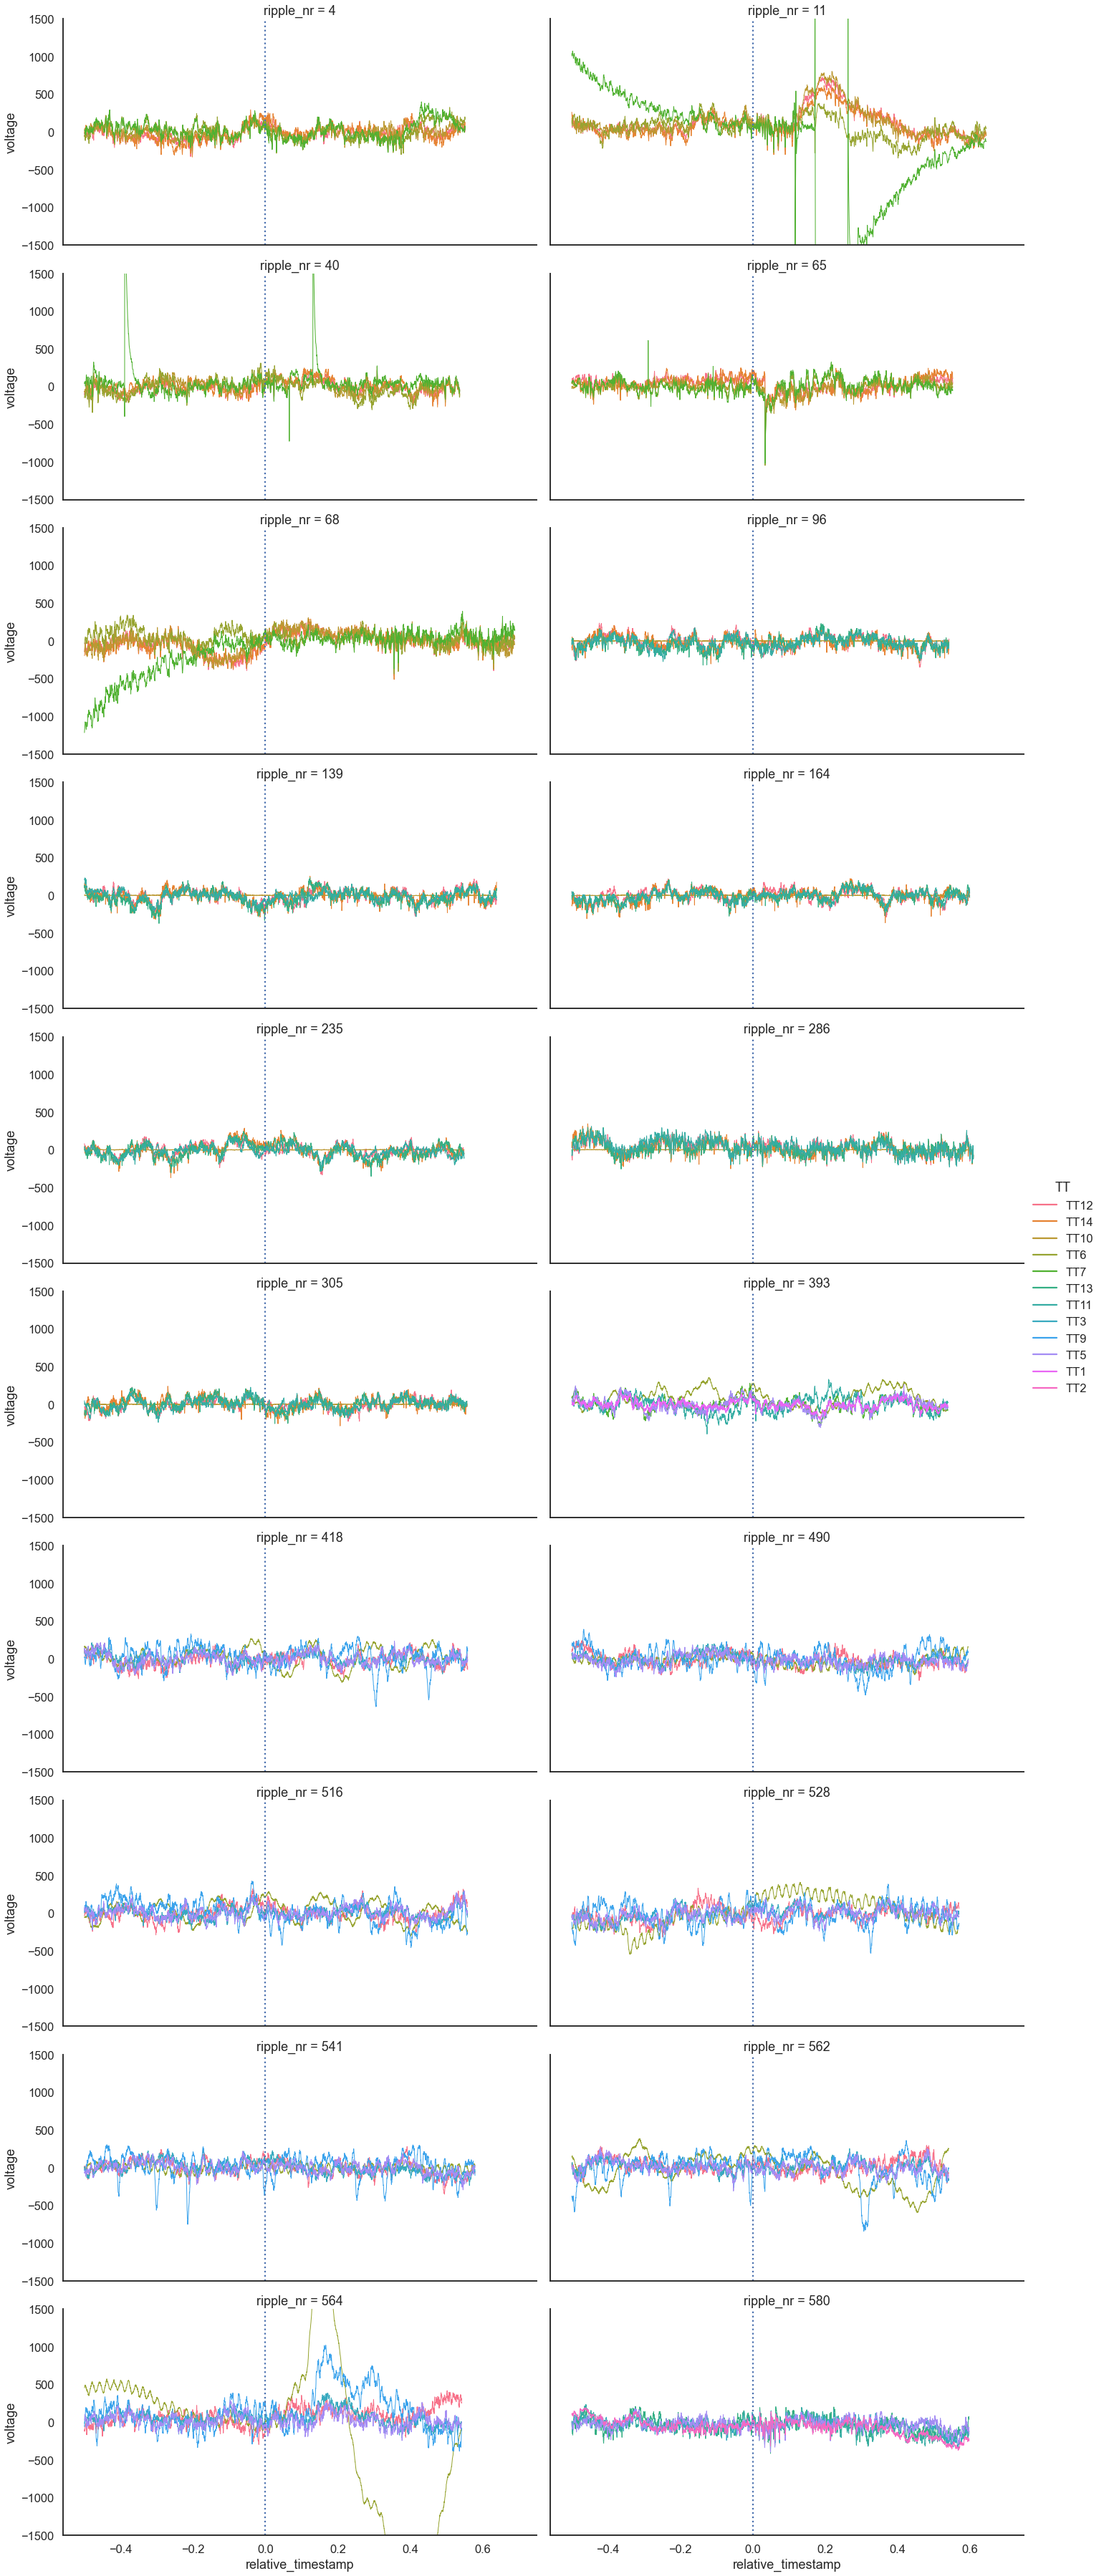

In [26]:
# Plot the data
sns.set(context='talk', style='white')
import matplotlib.pyplot as plt
plt.Figure(dpi=300)
g=sns.relplot(
    data=data,
    col='ripple_nr',
    col_wrap=2,
    kind='line',
    x='relative_timestamp',
    y='voltage',
    hue='TT',
    height=5,
    aspect=2, 
    linewidth=1
)

#Add vertical line indicating SWR onset
for ax in g.axes.flatten():
    ax.axvline(0, ls='dotted')
    ax.set_ylim([-1500,1500])
    
sns.despine()

##### Random inspection of CG PSD by ripple occurrence
No distinction between ripple type yet, just to check a few

#### Collapse to single average PSD by type and outcome
Includes:
1. Creating an average frequency to time PSD of CG activity;
2. Creating a variability heatmap to determine response consistency;
3. Create measurable output plot;

In [19]:
# Run psd for each tetrode and swr event
# Start with one example first and fully understand it
#from matplotlib.pyplot import specgram
#plt.Figure(dpi=300, figsize=(10,4))
#example=data.loc[(data.ripple_nr==68) & (data.TT=='TT12'), 'voltage']
##spec, freqs,t, im=specgram(x=example, pad_to=1500, Fs=3000, cmap='jet', )
#plt.ylim([0,150])
#plt.colorbar()
#sns.despine()
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html
# Once you are confortable, do it for each tetrode and swr event (average) and plot    

NameError: name 'data' is not defined

In [161]:
from scipy.signal import spectrogram

def calculate_frequency_and_spectrum(ripple_row, cg_data):
    '''
    Collect the frequency and power spectrum for each ripple to tetrode pair
    '''  
    # Get ripple number from the ripple row
    ripple_nr=ripple_row['ripple_nr']
    print('---',ripple_nr, '---')
    # With the ripple_nr, collect the TT data for that ripple stored in cg_data
    tt_data = cg_data[ripple_nr]
    
    ripple_tt_pair_density = []
    ripple_tt_pair_freqs=[]
    
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    for tt in tt_data.columns:
        freq, time, power_density = spectrogram(
            tt_data[tt], 
            fs=3000, 
            nperseg=512,
            scaling='density'
        )
        print(len(freq), len(time), len(power_density))
    
    ripple_tt_pair_density.append(power_density)
    ripple_tt_pair_freqs.append(freq)
    print(ripple_tt_pair_freqs)
    return ripple_tt_pair_density, ripple_tt_pair_freqs
    
def calculate_average_frequency_to_time_psd(df, cg_data):
    '''
    
    df - A pandas Dataframe with a specific set of ripples to analyse. This dataframe should contain
    ripples that have a shared characteristic (outcome or type).
    cg_data - Dictionary with ripple nr as keys with CG data (as a dataframe)
    '''
    freqs = []
    specs = []
    
    ripple_specs, ripple_freqs = df.apply(calculate_frequency_and_spectrum, args=(cg_data,), axis=1)   
    
    specs.append(ripple_specs)
    freqs.append(ripple_freqs) 
    
    #return np.mean(specs), np.var(specs), freqs
    


#### Collapse to single average PSD by SWR type
Similar to above but splitting by SWR type

In [162]:
ripples_analysis.groupby(['phase']).apply(
    calculate_average_frequency_to_time_psd, data_merged)

--- 6 ---
257 4 257
257 4 257
257 4 257
257 4 257
257 4 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
   

257 4 257
257 4 257
257 4 257
257 4 257
257 4 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.8

[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.4375  ,  404

257 6 257
257 6 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.57812

257 7 257
257 7 257
257 7 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 , 

[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.4375  ,  404

257 6 257
257 6 257
257 6 257
257 6 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  38

[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.4375  ,  404

[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.4375  ,  404

257 6 257
257 6 257
257 6 257
257 6 257
257 6 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.8

257 6 257
257 6 257
257 6 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 , 

257 5 257
257 5 257
257 5 257
257 5 257
257 5 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.8

257 4 257
257 4 257
257 4 257
257 4 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  38

257 7 257
257 7 257
257 7 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 , 

257 6 257
257 6 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.57812

[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.4375  ,  404

[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.4375  ,  404

257 7 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.43

[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.4375  ,  404

[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.4375  ,  404

257 6 257
[array([   0.      ,    5.859375,   11.71875 ,   17.578125,   23.4375  ,
         29.296875,   35.15625 ,   41.015625,   46.875   ,   52.734375,
         58.59375 ,   64.453125,   70.3125  ,   76.171875,   82.03125 ,
         87.890625,   93.75    ,   99.609375,  105.46875 ,  111.328125,
        117.1875  ,  123.046875,  128.90625 ,  134.765625,  140.625   ,
        146.484375,  152.34375 ,  158.203125,  164.0625  ,  169.921875,
        175.78125 ,  181.640625,  187.5     ,  193.359375,  199.21875 ,
        205.078125,  210.9375  ,  216.796875,  222.65625 ,  228.515625,
        234.375   ,  240.234375,  246.09375 ,  251.953125,  257.8125  ,
        263.671875,  269.53125 ,  275.390625,  281.25    ,  287.109375,
        292.96875 ,  298.828125,  304.6875  ,  310.546875,  316.40625 ,
        322.265625,  328.125   ,  333.984375,  339.84375 ,  345.703125,
        351.5625  ,  357.421875,  363.28125 ,  369.140625,  375.      ,
        380.859375,  386.71875 ,  392.578125,  398.43

ValueError: too many values to unpack (expected 2)

#### Collapse to single average PSD by SWR ype x outcome

In [ ]:
# Understand how spectogram funcion works - can be done on 16/11
# Finish up this code

#### Check for the effect of regionality
Do different regions of CG respond differently to the event? If so, does it make sense to move from random selection of tetrodes to analyse to specific tetrodes

In [ ]:
#first two weeks of february